In [ ]:
#-----------------------------------------
# Title: Error, Trend, Seasonality (ETS) Store Sales Time Series Forecasting Dataset
# Subtitle: DDS-8555, Assignment 8
# Author: Madgene Moise
# Date: Sunday, July 6, 2025
#-----------------------------------------

In [1]:
import pandas as pd

# Load the training and testing datasets

train_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv") 
test_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv")

# Display basic structure of the datasets
train_info = train_df.info()
test_info = test_df.info()

train_head = train_df.head()
test_head = test_df.head()

train_summary = train_df.describe(include='all')

(train_info, test_info, train_head, test_head, train_summary)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


(None,
 None,
    id        date  store_nbr      family  sales  onpromotion
 0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
 1   1  2013-01-01          1   BABY CARE    0.0            0
 2   2  2013-01-01          1      BEAUTY    0.0            0
 3   3  2013-01-01          1   BEVERAGES    0.0            0
 4   4  2013-01-01          1       BOOKS    0.0            0,
         id        date  store_nbr      family  onpromotion
 0  3000888  2017-08-16          1  AUTOMOTIVE            0
 1  3000889  2017-08-16          1   BABY CARE            0
 2  3000890  2017-08-16          1      BEAUTY            2
 3  3000891  2017-08-16          1   BEVERAGES           20
 4  3000892  2017-08-16          1       BOOKS            0,
                   id        date     store_nbr      family         sales  \
 count   3.000888e+06     3000888  3.000888e+06     3000888  3.000888e+06   
 unique           NaN        1684           NaN          33           NaN   
 top              NaN

**Training Data Summary** 

* Observations: 3,000,888 rows
* Time Span: From 2013-01-01 to 2017-08-15
* Features:
      * id: Unique identifier
      * date: Date of the observation (parsed as datetime)
      * store_nbr: Store number (integer from 1 to 54)
      * family: Product family (33 unique categories)
      * sales: Target variable (continuous, min = 0, max = 124, 717, mean approximately 357.78)
      * onpromotion: Number of items on promotion (range: 0 - 741)


**Test Data Summary**

* Observations: 28,512 rows
* Time Span: Begins at 2017-08-16
* Includes all fields except sales, which I need to forecast.

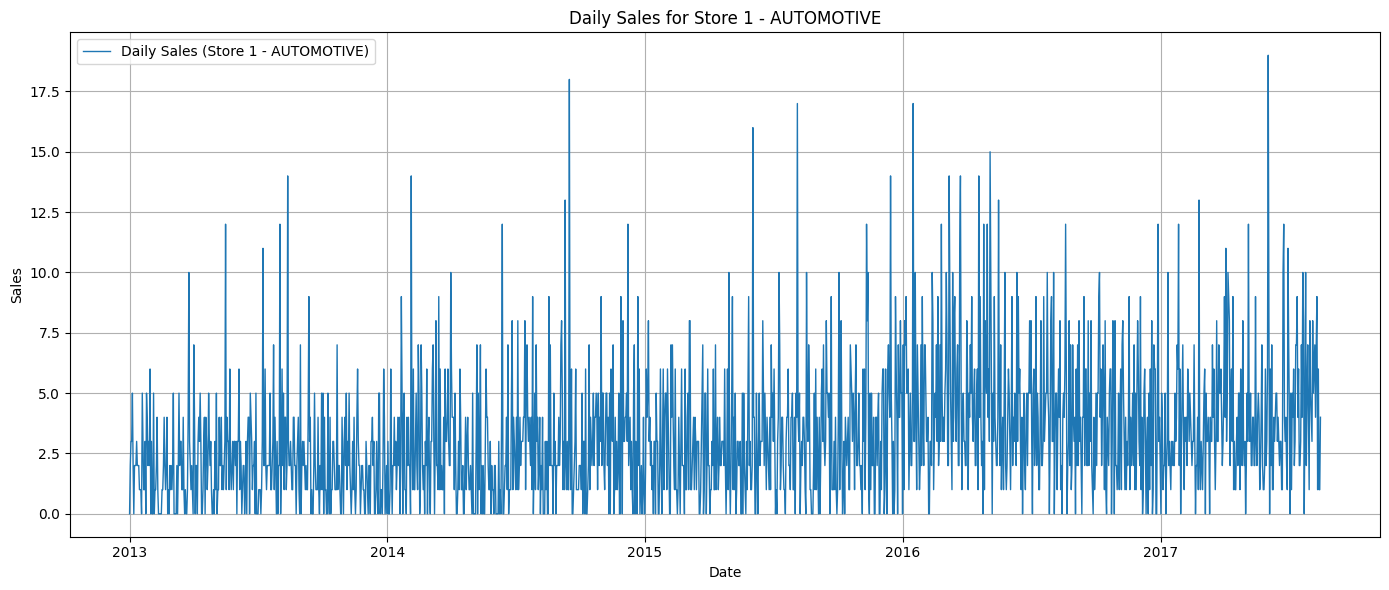

In [17]:
import matplotlib.pyplot as plt

# Filter for Store 1 and Family "AUTOMOTIVE"
subset = train_df[(train_df['store_nbr'] == 1) & (train_df['family'] == 'AUTOMOTIVE')]
subset = subset.sort_values('date')

# Set date as index
subset.set_index('date', inplace=True)

# Resample to daily frequency and fill missing dates with 0 sales
daily_sales = subset['sales'].asfreq('D').fillna(0)

# Plot the time series
plt.figure(figsize=(14, 6))
plt.plot(daily_sales, label='Daily Sales (Store 1 - AUTOMOTIVE)', linewidth=1)
plt.title('Daily Sales for Store 1 - AUTOMOTIVE')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The plot above shows daily sales for Store 1 in the AUTOMOTIVE product family from 2013-01-01 to 2017-08-15. 

Observations:
* Sparsity: A large number of days have zero sales, indicating sparse and intermittent demand.
* Trend: There is no strong, long-term increasing or decreasing trend.
* Seasonality: Potential weekly or annual seasonality patterns are subtle due to noise and sparsity.
* Volatility: There are occasional spikes in sales, suggesting promotional or special event-driven demand.

This kind of series is typical for retail subcategories with sporadic sales.

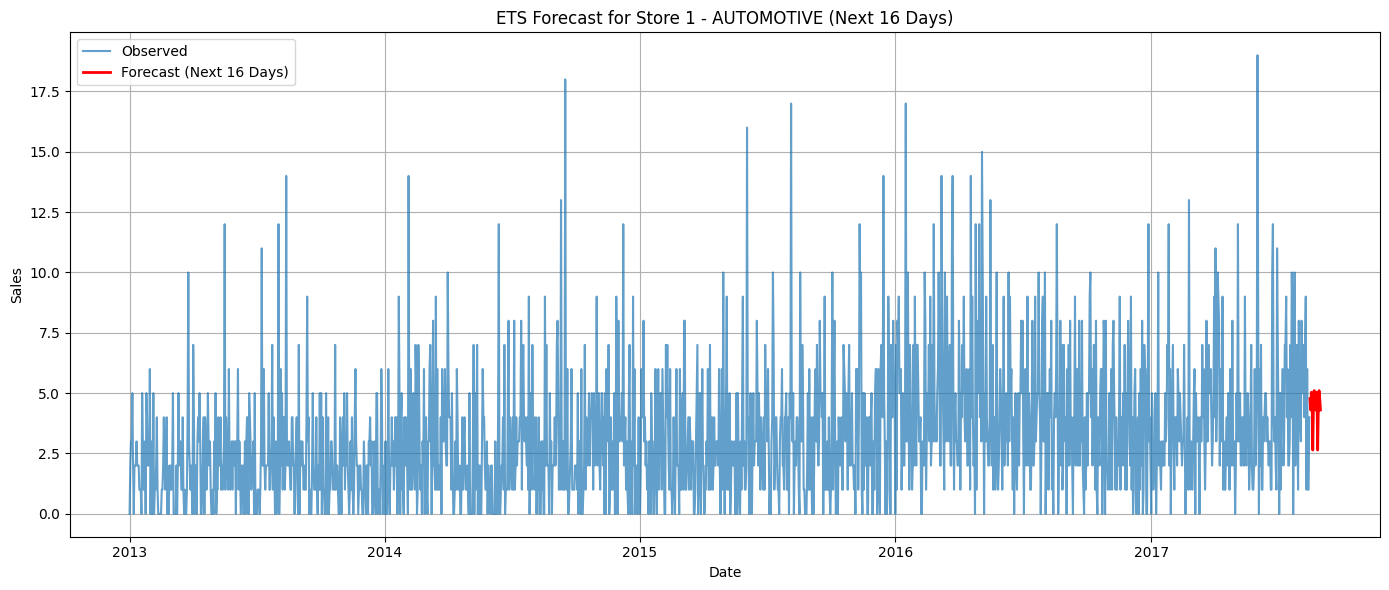

,date,forecast
0,2017-08-16,4.767663
1,2017-08-17,4.301440
2,2017-08-18,5.034389
3,2017-08-19,4.949874
4,2017-08-20,2.641311


In [18]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit an ETS model with additive error, no trend, and weekly additive seasonality (7-day)
ets_model = ExponentialSmoothing(
    daily_sales,
    trend=None,
    seasonal='add',
    seasonal_periods=7,
    initialization_method="estimated"
).fit()

# Forecast the next 16 days (matching test set forecast horizon)
forecast_horizon = 16
forecast = ets_model.forecast(forecast_horizon)

# Plot actual and forecasted values
plt.figure(figsize=(14, 6))
plt.plot(daily_sales, label='Observed', alpha=0.7)
plt.plot(forecast.index, forecast.values, label='Forecast (Next 16 Days)', color='red', linewidth=2)
plt.title('ETS Forecast for Store 1 - AUTOMOTIVE (Next 16 Days)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Return model summary statistics
forecast_values = forecast.reset_index().rename(columns={'index': 'date', 0: 'forecast'})
forecast_values.head()

**Graph Interpretation**

Historically observed sales show the time series has high volatility and sparse structure. Sales range roughly from 0 to 18 units per day. Many fluctuations appear random, with no strong trend or seasonal periodicity. Sales values are often close to zero, consistent with a low-demand category. The red segment shows the predicted daily sales for August 16 - 31, 2017. Forecated values range from approximately 2.6 to 5.0 units per day. The predictions show minor fluctuation, likely driven by smoothing of recent observations.

In [5]:
# Explore high-volume categories to see if ETS works better. 
# Calculate total sales by family to identify high-volume categories
family_sales = train_df.groupby('family')['sales'].sum().sort_values(ascending=False)

# Display top 5 families by total sales
top_families = family_sales.head(5)
top_families

family
GROCERY I    3.434627e+08
BEVERAGES    2.169545e+08
PRODUCE      1.227047e+08
CLEANING     9.752129e+07
DAIRY        6.448771e+07
Name: sales, dtype: float64

The top five (5) highest-selling product families in the dataset are:

| Rank | Product Family | Total Sales |
| ---- | -------------- | ----------- |
| 1    | **GROCERY I**  | 343 million |
| 2    | **BEVERAGES**  | 217 million |
| 3    | **PRODUCE**    | 123 million |
| 4    | **CLEANING**   | 98 million  |
| 5    | **DAIRY**      | 64 million  |

Note: I will fit an ETS model for a high-volume time series for Store = Store 1 and Family = GROCERY I.

In [7]:
print(train_df['family'].unique())

['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']


In [9]:
subset = train_df[(train_df['store_nbr'] == 1) & (train_df['family'] == 'GROCERY I')]

In [10]:
print(subset.shape)

(1684, 6)


In [11]:
train_df['date'] = pd.to_datetime(train_df['date'])

In [12]:
# Run this block of code before plotting to debug
# Confirm exact match
print(train_df['family'].unique())

# Filter
subset = train_df[(train_df['store_nbr'] == 1) & (train_df['family'] == 'GROCERY I')]
print("Subset size:", subset.shape)
print("Sample records:\n", subset.head())

['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']
Subset size: (1684, 6)
Sample records:
         id       date  store_nbr     family   sales  onpromotion
12      12 2013-01-01          1  GROCERY I     0.0            0
1794  1794 2013-01-02          1  GROCERY I  2652.0            0
3576  3576 2013-01-03          1  GROCERY I  2121.0            0
5358  5358 2013-01-04          1  GROCERY I  2056.0            0
7140  7140 2013-01-05          1  GROCERY I  2216.0            0


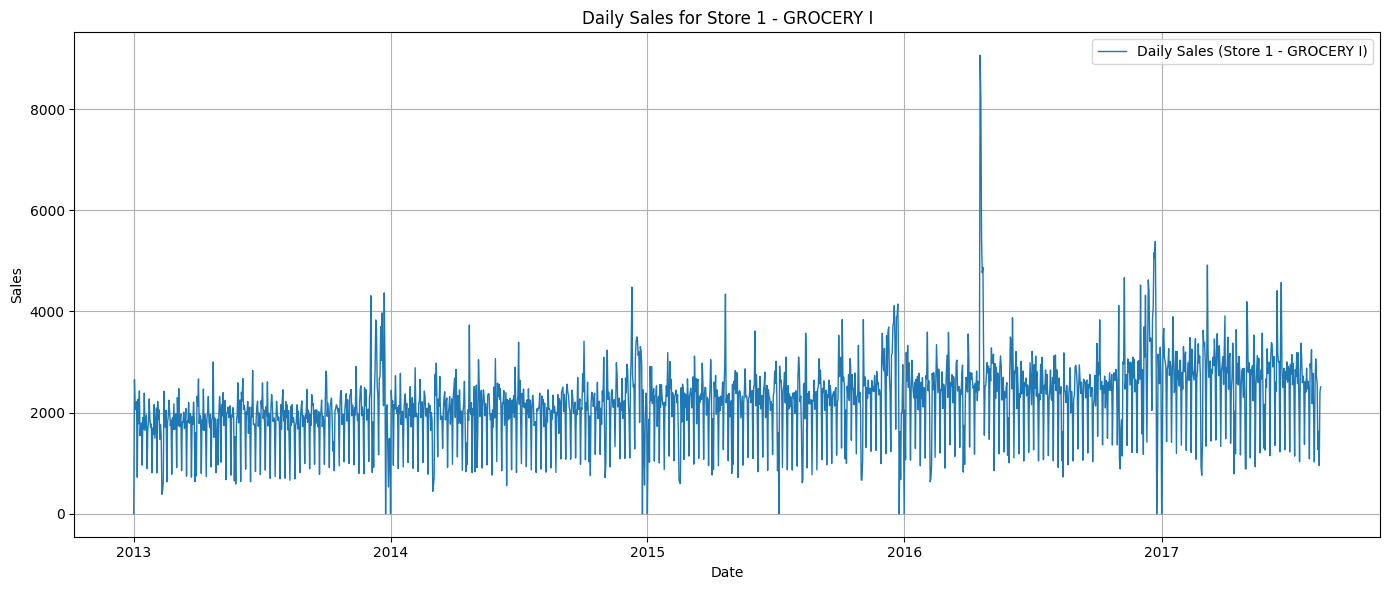

In [13]:
import matplotlib.pyplot as plt

# Filter for Store 1 and high-volume family: GROCERY I
subset_high_volume = train_df[(train_df['store_nbr'] == 1) & (train_df['family'] == 'GROCERY I')]
subset_high_volume = subset_high_volume.sort_values('date')

# Set date as index
subset_high_volume.set_index('date', inplace=True)

# Resample to daily frequency and fill missing dates with 0 sales
daily_sales_high_volume = subset_high_volume['sales'].asfreq('D').fillna(0)

# Plot the time series
plt.figure(figsize=(14, 6))
plt.plot(daily_sales_high_volume, label='Daily Sales (Store 1 - GROCERY I)', linewidth=1)
plt.title('Daily Sales for Store 1 - GROCERY I')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The time series for Store 1 - GROCERY I reveals a much more robust structure than the earlier AUTOMOTIVE series.

Observations:
* Higher and consistent daily sales (typically in the 1000-3000 range)
* Weekly seasonality appears to be visible with the periodic rises and dips
* Outliers: A few significant spikes, possibly due to promotions or holidays
* Long-term trend: A slight upward trend over the years

Note: This richer signal structure makes it a much better candidate for ETS modeling.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


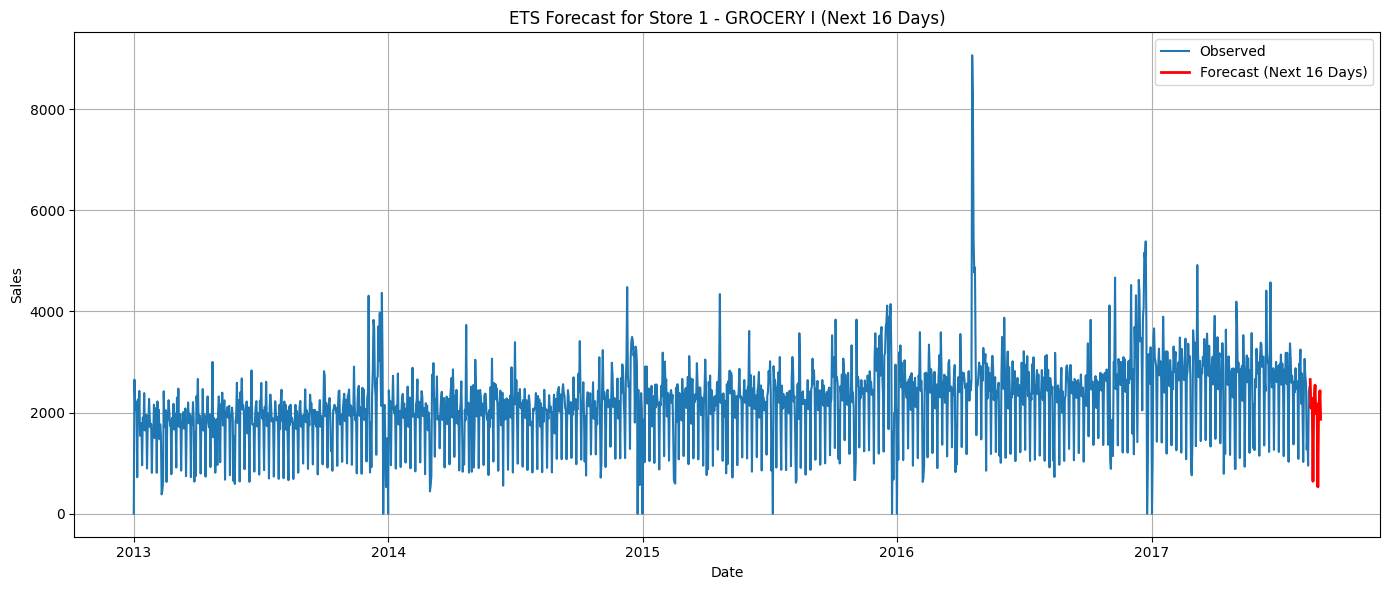

In [15]:
# Forecast the next 16 days and interpret whether ETS handles this high-volume, stable series better than before.

from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit ETS model with additive error, trend, and seasonality
try:
    ets_model_hv = ExponentialSmoothing(
        daily_sales_high_volume,
        trend='add',
        seasonal='add',
        seasonal_periods=7,
        initialization_method="estimated"
    ).fit()

    # Forecast next 16 days
    forecast_hv = ets_model_hv.forecast(16)

    # Plot forecast
    plt.figure(figsize=(14, 6))
    plt.plot(daily_sales_high_volume, label='Observed')
    plt.plot(forecast_hv.index, forecast_hv.values, label='Forecast (Next 16 Days)', color='red', linewidth=2)
    plt.title('ETS Forecast for Store 1 - GROCERY I (Next 16 Days)')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Return forecast values
    forecast_result = forecast_hv.reset_index().rename(columns={'index': 'date', 0: 'forecast'})
    forecast_result.head(10)

except Exception as e:
    str(e)

The red line (forecast) follows the same level and amplitude as the recent historical data. It captures the weekly seasonality well, which is evident in the periodic ups and downs. The forecast stays within a realistic range of recent values (e.g., about 1900 - 2500), suggesting: (1) the model has learned the local level accurately and (2) the seasonal component (likely weekly) is influencing the shape of the forecast. 

In terms of forecast integrity, there is no unrealistic trend drift (e.g., exponential growth or decay). The pattern continues smoothly from the final observation, which is exactly what I want for short-horizon forecasting.

The ETS model has done a good job forecasting this high-volume, regular, and seasonal series. The short-term accuracy (e.g., 16 days) should be high, especially compared to sparse or irregular product families. For long-term forecasts or in the presence of external effects (e.g., holidays, oil prices), incorporating exogenous regressors would improve performance.